# Inference of the U2OS interactome

---
In this notebook we will derive the interactome of U2OS cells using the Prize-collecting Steiner tree algorithm.

---

## 0. Environmental setup

In [1]:
import numpy as np
import pandas as pd
from pcst_fast import pcst_fast
import networkx as nx
import random
from tqdm import tqdm
import community
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

seed = 1234
np.random.seed(seed)
random.seed(seed)

%load_ext nb_black

<IPython.core.display.Javascript object>

In [66]:
def run_pcst_sensitivity_analyses(
    graph,
    bs,
    prize_key: str = "prize",
    weight_key: str = "cost",
    minmax_scale: bool = False,
):
    node_dict = dict(zip(list(graph.nodes()), list(range(len(graph.nodes())))))
    inv_edge_dict = dict(zip(list(range(len(graph.edges()))), list(graph.edges())))

    vertices = list(node_dict.values())
    edges = []
    prizes = []
    costs = []
    for node in graph.nodes(data=True):
        prizes.append(node[-1][prize_key])
    for edge in graph.edges(data=True):
        edges.append((node_dict[edge[0]], node_dict[edge[1]]))
        costs.append(edge[-1][weight_key])

    edges = np.array(edges)
    prizes = np.array(prizes)
    if minmax_scale:
        prizes = (prizes - prizes.min()) / (prizes.max() - prizes.min())
    costs = np.array(costs)

    pcs_tree_dict = {}
    augmented_pcs_tree_dict = {}

    for b in tqdm(bs, desc="Compute PCSTs"):
        v_idc, e_idc = pcst_fast(edges, prizes * b, costs, -1, 1, "strong", 0)
        selected_edges = [inv_edge_dict[e_idx] for e_idx in e_idc]
        # print(selected_edges)
        pcs_tree = graph.edge_subgraph(selected_edges)
        augmented_pcs_tree = graph.subgraph(pcs_tree.nodes())
        pcst_name = graph.name + "_b_{}".format(b)
        pcs_tree_dict[pcst_name] = pcs_tree
        augmented_pcs_tree_dict[pcst_name + "_augmented"] = augmented_pcs_tree
    return pcs_tree_dict, augmented_pcs_tree_dict

<IPython.core.display.Javascript object>

In [3]:
def analyze_pcst_sensitivity_analyses_results(trees_dict, target_nodes, death_nodes):
    data = {
        "beta": [],
        "n_nodes": [],
        "n_edges": [],
        "n_connected_components": [],
        "n_louvain_clusters": [],
        "avg_node_degree": [],
        "std_node_degree": [],
        "n_leaf_nodes": [],
        "n_target_nodes": [],
        "n_target_leafs": [],
        "avg_target_degree": [],
        "std_target_degree": [],
        "n_death_nodes": [],
    }
    keys = []
    for key, tree in tqdm(trees_dict.items(), desc="Analyze tree"):
        keys.append(key)
        splitted = key.split("_")
        beta = splitted[-1]

        n_nodes = len(tree.nodes())
        n_edges = len(tree.edges())
        n_connected_components = nx.number_connected_components(tree)
        n_louvain_clusters = len(
            np.unique(list(community.best_partition(tree).values()))
        )
        node_degrees = []
        target_degrees = []
        leaf_nodes = []
        for node in tree.nodes():
            node_degree = tree.degree(node)
            node_degrees.append(node_degree)
            if node_degree == 1:
                leaf_nodes.append(node)
            if node in target_nodes:
                target_degrees.append(node_degree)
        avg_node_degree = np.mean(node_degrees)
        std_node_degree = np.std(node_degrees)
        avg_target_degree = np.mean(target_degrees)
        std_target_degree = np.std(target_degrees)
        n_target_leafs = len(set(target_nodes).intersection(set(leaf_nodes)))
        n_leaf_nodes = len(leaf_nodes)
        n_target_nodes = len(set(target_nodes).intersection(set(list(tree.nodes()))))
        n_death_nodes = len(set(death_nodes).intersection(set(list(tree.nodes()))))

        data["beta"].append(float(beta))
        data["n_nodes"].append(n_nodes)
        data["n_edges"].append(n_edges)
        data["n_connected_components"].append(n_connected_components)
        data["n_louvain_clusters"].append(n_louvain_clusters)
        data["avg_node_degree"].append(avg_node_degree)
        data["std_node_degree"].append(std_node_degree)
        data["n_leaf_nodes"].append(n_leaf_nodes)
        data["n_target_nodes"].append(n_target_nodes)
        data["n_target_leafs"].append(n_target_leafs)
        data["avg_target_degree"].append(avg_target_degree)
        data["std_target_degree"].append(std_target_degree)
        data["n_death_nodes"].append(n_death_nodes)

    data = pd.DataFrame.from_dict(data)
    data.index = keys
    return data

<IPython.core.display.Javascript object>

In [4]:
def plot_node_ious(pcst_dict):
    fig, ax = plt.subplots(figsize=[6, 4])
    n = len(pcst_dict)
    node_ious = np.zeros([n, n])
    trees = list(pcst_dict.values())
    for i in tqdm(range(n - 1)):
        for j in range(i + 1, n):
            nodes_i = set(list(trees[i].nodes()))
            nodes_j = set(list(trees[j].nodes()))

            if len(nodes_i.union(nodes_j)) == 0:
                node_ious[i, j] = 0
            else:
                node_ious[i, j] = len(nodes_i.intersection(nodes_j)) / len(
                    nodes_i.union(nodes_j)
                )
    node_ious = node_ious + np.transpose(node_ious) + np.diag(np.ones(n))
    ax = sns.heatmap(node_ious, ax=ax, cmap="viridis")
    ax.set_xlabel("trees")
    ax.set_ylabel("trees")
    plt.title("IoU of nodes in the tree solutions")
    plt.show()
    plt.close()

<IPython.core.display.Javascript object>

---

## 1. Read in data

In [5]:
## Version 1: Prizes = absolute logFC in CCLE data set, Weights = 1-|Spearman correlation|
ppi_v1 = nx.read_gpickle(
    "../../../data/ppi/ppi_confidence_pruned_0542_ccle_abslogfc_spearmanr.pkl"
)
ppi_v1.name = "Confidence_Pruned_CCLE_absLogFC_Spearman_r"
print(nx.info(ppi_v1))

## Version 1: Prizes = absolute logFC in CCLE data set, Weights = bootstrap p-value of non-zero Spearman correlation
ppi_v2 = nx.read_gpickle(
    "../../../data/ppi/ppi_confidence_pruned_0542_ccle_abslogfc_spearmanp.pkl"
)
ppi_v2.name = "Confidence_Pruned_CCLE_absLogFC_Spearman_p"
print(nx.info(ppi_v2))

## Version 3: Prizes = absolute logFC in CCLE data set or max absolute logFC if ORF target,
## Weights = 1-|Spearman correlation|
ppi_v3 = nx.read_gpickle(
    "../../../data/ppi/ppi_confidence_pruned_0542_ccle_abslogfc_orf_maxp_spearmanr.pkl"
)
ppi_v3.name = "Confidence_Pruned_CCLE_absLogFC_ORF_max_Spearman_r"
print(nx.info(ppi_v3))

## Version 4: Prizes = absolute logFC in CCLE data set or max absolute logFCif ORF target,
## Weights = bootstrap p-value of non-zero Spearman correlation
ppi_v4 = nx.read_gpickle(
    "../../../data/ppi/ppi_confidence_pruned_0542_ccle_abslogfc_orf_maxp_spearmanp.pkl"
)
ppi_v4.name = "Confidence_Pruned_CCLE_absLogFC__ORF_max_Spearman_p"
print(nx.info(ppi_v4))

Name: Confidence_Pruned_CCLE_absLogFC_Spearman_r
Type: Graph
Number of nodes: 10841
Number of edges: 54550
Average degree:  10.0636
Name: Confidence_Pruned_CCLE_absLogFC_Spearman_p
Type: Graph
Number of nodes: 10841
Number of edges: 54550
Average degree:  10.0636
Name: Confidence_Pruned_CCLE_absLogFC_ORF_max_Spearman_r
Type: Graph
Number of nodes: 10841
Number of edges: 54550
Average degree:  10.0636
Name: Confidence_Pruned_CCLE_absLogFC__ORF_max_Spearman_p
Type: Graph
Number of nodes: 10841
Number of edges: 54550
Average degree:  10.0636


<IPython.core.display.Javascript object>

In [6]:
orf_targets = set(
    pd.read_csv(
        "../../../data/other/selected_orf_targets.txt", index_col=0, header=None
    ).index
)
death_genes = list(
    pd.read_csv("../../../data/other/reactome_cell_death.tsv", index_col=0, sep="\t")[
        "MoleculeName"
    ]
)
death_genes = set([gene.split(" ")[-1] for gene in death_genes])

<IPython.core.display.Javascript object>

---

## 2. Run PCST-based inference

Using the above data, we will approximately solve the PCST problem for different choice of $\beta$ in the PCST objectives, i.e. the prize factor. We aim to identify a stable subgraph from the confidence pruned humna PPI that describes the cell-type specific interactome of U2OS cells best.

### 2a. Interactome version 1

We will first infer the interactome for the first choice of input network, i.e. where the node prizes are given by the absolute logFC comparing U2OS cells against over 1300 other cancer cell lines in the CCLE data set and the edge weights are given by $1-|r_{Spearman}|$.

In [8]:
bs = np.arange(0, 10, 0.1)
pcst_dict_v1, augmented_pcst_dict_v1 = run_pcst_sensitivity_analyses(
    graph=ppi_v1, bs=bs
)
pcst_results_v1 = analyze_pcst_sensitivity_analyses_results(
    pcst_dict_v1, target_nodes=orf_targets, death_nodes=death_genes
)

Analyze tree:   0%|          | 0/100 [00:00<?, ?it/s]/home/paysan_d/miniconda3/envs/image2reg/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/paysan_d/miniconda3/envs/image2reg/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/paysan_d/miniconda3/envs/image2reg/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/paysan_d/miniconda3/envs/image2reg/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/paysan_d/miniconda3/envs/image2reg/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value enco

<IPython.core.display.Javascript object>

100%|██████████| 99/99 [01:11<00:00,  1.38it/s]


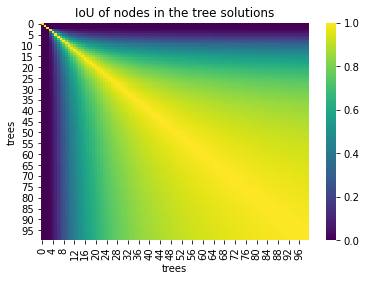

<IPython.core.display.Javascript object>

In [9]:
plot_node_ious(pcst_dict_v1)

### 2b. Interactome version 3

The only difference in the setup of version 3 is that we set the prize for all ORF targets to the maximum of the other prizes promote solutions that include those targets as we are interested in finding the interactome spanning those nodes and thus describing their regulatory relationships.

In [65]:
pcst_dict_v3, augmented_pcst_dict_v3 = run_pcst_sensitivity_analyses(
    graph=ppi_v3, bs=bs
)
pcst_results_v3 = analyze_pcst_sensitivity_analyses_results(
    pcst_dict_v3, target_nodes=orf_targets, death_nodes=death_genes
)

Compute PCSTs:   1%|          | 1/100 [00:00<00:07, 13.83it/s]


TypeError: unhashable type: 'dict'

<IPython.core.display.Javascript object>

100%|██████████| 99/99 [01:26<00:00,  1.14it/s]


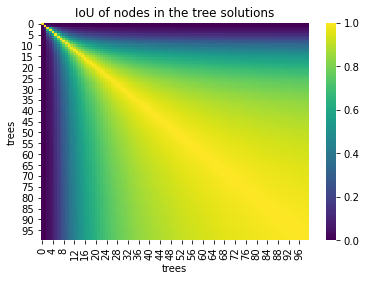

<IPython.core.display.Javascript object>

In [11]:
plot_node_ious(pcst_dict_v3)

### 2c. Interactome version 2

The setup is as in version 1 but this time the edge weight is given by the bootstrap p-value for testing for zero Spearman correlation.

In [167]:
pcst_dict_v2, augmented_pcst_dict_v2 = run_pcst_sensitivity_analyses(
    graph=ppi_v2, bs=bs
)
pcst_results_v2 = analyze_pcst_sensitivity_analyses_results(
    pcst_dict_v2, target_nodes=orf_targets, death_nodes=death_genes
)

Analyze tree: 100%|██████████| 100/100 [02:05<00:00,  1.25s/it]


<IPython.core.display.Javascript object>

100%|██████████| 99/99 [01:51<00:00,  1.13s/it]


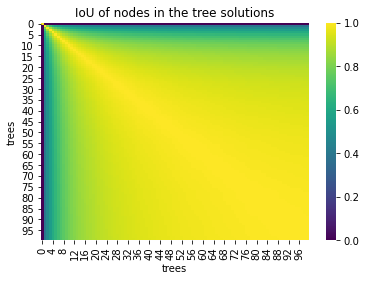

<IPython.core.display.Javascript object>

In [213]:
plot_node_ious(pcst_dict_v2)

### 2d. Interactome version 4

As in version two but with ORF prizes set to the maximum abs logFC.

In [34]:
pcst_dict_v4, augmented_pcst_dict_v4 = run_pcst_sensitivity_analyses(
    graph=ppi_v4, bs=bs
)
pcst_results_v4 = analyze_pcst_sensitivity_analyses_results(
    pcst_dict_v4, target_nodes=orf_targets, death_nodes=death_genes
)

Analyze tree: 100%|██████████| 100/100 [01:56<00:00,  1.17s/it]


<IPython.core.display.Javascript object>

100%|██████████| 99/99 [01:49<00:00,  1.10s/it]


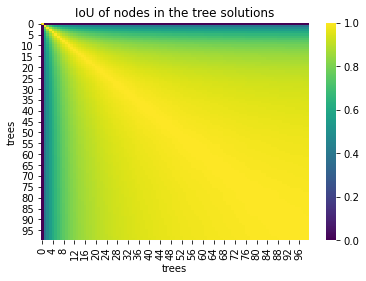

<IPython.core.display.Javascript object>

In [35]:
plot_node_ious(pcst_dict_v4)

---

### 2e. Visualization of the results

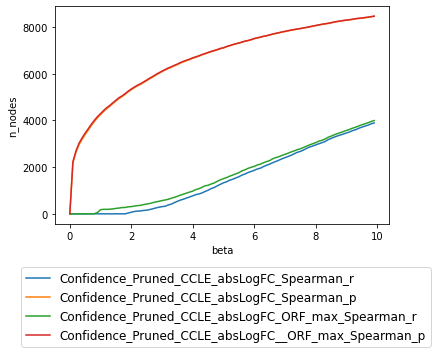

<IPython.core.display.Javascript object>

In [171]:
fig, ax = plt.subplots()
sns.lineplot(
    data=pcst_results_v1_scaled, x="beta", y="n_nodes", ax=ax, label=ppi_v1.name
)
sns.lineplot(
    data=pcst_results_v2_scaled, x="beta", y="n_nodes", ax=ax, label=ppi_v2.name
)
sns.lineplot(
    data=pcst_results_v3_scaled, x="beta", y="n_nodes", ax=ax, label=ppi_v3.name
)
sns.lineplot(
    data=pcst_results_v4_scaled, x="beta", y="n_nodes", ax=ax, label=ppi_v4.name
)
plt.legend(
    bbox_to_anchor=(-0.1, -0.2), loc=2, borderaxespad=0, ncol=1, prop={"size": 12}
)
plt.show()

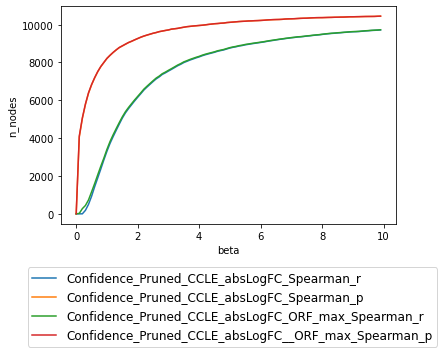

<IPython.core.display.Javascript object>

In [175]:
fig, ax = plt.subplots()
sns.lineplot(data=pcst_results_v1, x="beta", y="n_nodes", ax=ax, label=ppi_v1.name)
sns.lineplot(data=pcst_results_v2, x="beta", y="n_nodes", ax=ax, label=ppi_v2.name)
sns.lineplot(data=pcst_results_v3, x="beta", y="n_nodes", ax=ax, label=ppi_v3.name)
sns.lineplot(data=pcst_results_v4, x="beta", y="n_nodes", ax=ax, label=ppi_v4.name)
plt.legend(
    bbox_to_anchor=(-0.1, -0.2), loc=2, borderaxespad=0, ncol=1, prop={"size": 12}
)
plt.show()

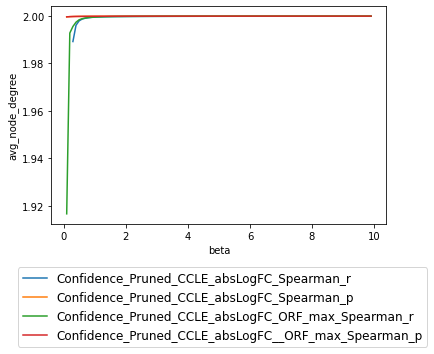

<IPython.core.display.Javascript object>

In [176]:
fig, ax = plt.subplots()
sns.lineplot(
    data=pcst_results_v1, x="beta", y="avg_node_degree", ax=ax, label=ppi_v1.name
)
sns.lineplot(
    data=pcst_results_v2, x="beta", y="avg_node_degree", ax=ax, label=ppi_v2.name
)
sns.lineplot(
    data=pcst_results_v3, x="beta", y="avg_node_degree", ax=ax, label=ppi_v3.name
)
sns.lineplot(
    data=pcst_results_v4, x="beta", y="avg_node_degree", ax=ax, label=ppi_v4.name
)
plt.legend(
    bbox_to_anchor=(-0.1, -0.2), loc=2, borderaxespad=0, ncol=1, prop={"size": 12}
)
plt.show()

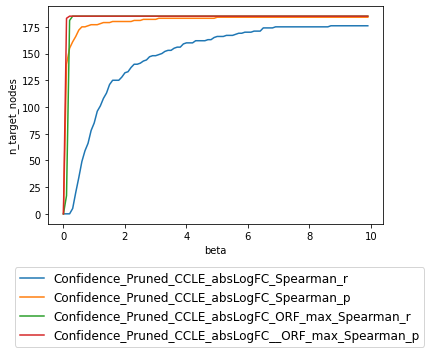

<IPython.core.display.Javascript object>

In [177]:
fig, ax = plt.subplots()
sns.lineplot(
    data=pcst_results_v1, x="beta", y="n_target_nodes", ax=ax, label=ppi_v1.name
)
sns.lineplot(
    data=pcst_results_v2, x="beta", y="n_target_nodes", ax=ax, label=ppi_v2.name
)
sns.lineplot(
    data=pcst_results_v3, x="beta", y="n_target_nodes", ax=ax, label=ppi_v3.name
)
sns.lineplot(
    data=pcst_results_v4, x="beta", y="n_target_nodes", ax=ax, label=ppi_v4.name
)
plt.legend(
    bbox_to_anchor=(-0.1, -0.2), loc=2, borderaxespad=0, ncol=1, prop={"size": 12}
)
plt.show()

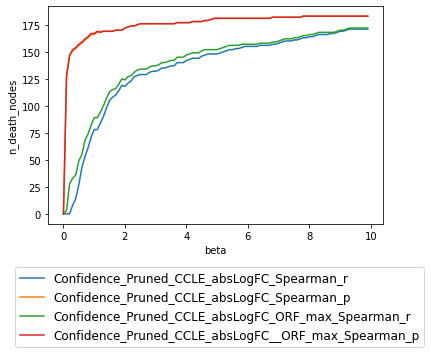

<IPython.core.display.Javascript object>

In [178]:
fig, ax = plt.subplots()
sns.lineplot(
    data=pcst_results_v1, x="beta", y="n_death_nodes", ax=ax, label=ppi_v1.name
)
sns.lineplot(
    data=pcst_results_v2, x="beta", y="n_death_nodes", ax=ax, label=ppi_v2.name
)
sns.lineplot(
    data=pcst_results_v3, x="beta", y="n_death_nodes", ax=ax, label=ppi_v3.name
)
sns.lineplot(
    data=pcst_results_v4, x="beta", y="n_death_nodes", ax=ax, label=ppi_v4.name
)
plt.legend(
    bbox_to_anchor=(-0.1, -0.2), loc=2, borderaxespad=0, ncol=1, prop={"size": 12}
)
plt.show()

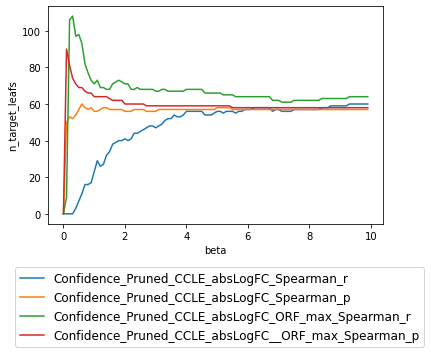

<IPython.core.display.Javascript object>

In [179]:
fig, ax = plt.subplots()
sns.lineplot(
    data=pcst_results_v1, x="beta", y="n_target_leafs", ax=ax, label=ppi_v1.name
)
sns.lineplot(
    data=pcst_results_v2, x="beta", y="n_target_leafs", ax=ax, label=ppi_v2.name
)
sns.lineplot(
    data=pcst_results_v3, x="beta", y="n_target_leafs", ax=ax, label=ppi_v3.name
)
sns.lineplot(
    data=pcst_results_v4, x="beta", y="n_target_leafs", ax=ax, label=ppi_v4.name
)
plt.legend(
    bbox_to_anchor=(-0.1, -0.2), loc=2, borderaxespad=0, ncol=1, prop={"size": 12}
)
plt.show()

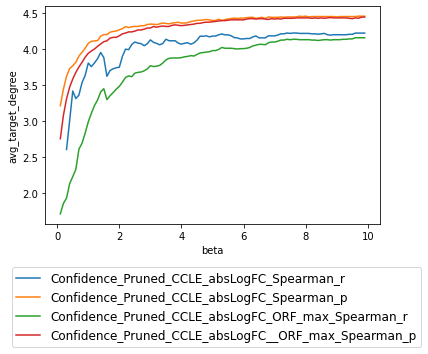

<IPython.core.display.Javascript object>

In [180]:
fig, ax = plt.subplots()
sns.lineplot(
    data=pcst_results_v1, x="beta", y="avg_target_degree", ax=ax, label=ppi_v1.name
)
sns.lineplot(
    data=pcst_results_v2, x="beta", y="avg_target_degree", ax=ax, label=ppi_v2.name
)
sns.lineplot(
    data=pcst_results_v3, x="beta", y="avg_target_degree", ax=ax, label=ppi_v3.name
)
sns.lineplot(
    data=pcst_results_v4, x="beta", y="avg_target_degree", ax=ax, label=ppi_v4.name
)
plt.legend(
    bbox_to_anchor=(-0.1, -0.2), loc=2, borderaxespad=0, ncol=1, prop={"size": 12}
)
plt.show()

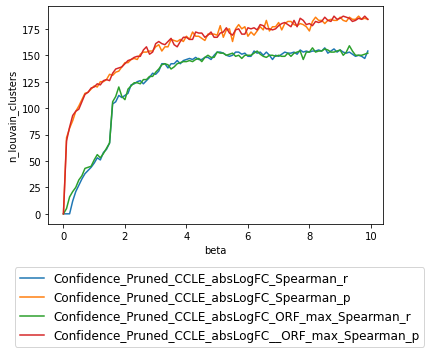

<IPython.core.display.Javascript object>

In [181]:
fig, ax = plt.subplots()
sns.lineplot(
    data=pcst_results_v1, x="beta", y="n_louvain_clusters", ax=ax, label=ppi_v1.name
)
sns.lineplot(
    data=pcst_results_v2, x="beta", y="n_louvain_clusters", ax=ax, label=ppi_v2.name
)
sns.lineplot(
    data=pcst_results_v3, x="beta", y="n_louvain_clusters", ax=ax, label=ppi_v3.name
)
sns.lineplot(
    data=pcst_results_v4, x="beta", y="n_louvain_clusters", ax=ax, label=ppi_v4.name
)
plt.legend(
    bbox_to_anchor=(-0.1, -0.2), loc=2, borderaxespad=0, ncol=1, prop={"size": 12}
)
plt.show()

---

## 3. Extended analyses of the resulting tree solution

In [133]:
pcst = pcst_dict_v4["Confidence_Pruned_CCLE_absLogFC__ORF_max_Spearman_p_b_1.0"]
print(nx.info(pcst))

Name: Confidence_Pruned_CCLE_absLogFC_ORF_max_Spearman_p_b_1
Type: Graph
Number of nodes: 8219
Number of edges: 8218
Average degree:   1.9998


<IPython.core.display.Javascript object>

In [134]:
pcst.name = "Confidence_Pruned_CCLE_absLogFC_ORF_max_Spearman_p_b_1"

<IPython.core.display.Javascript object>

In [143]:
dict(sorted(dict(ppi_v3.degree()).items(), key=lambda item: item[1], reverse=True))

{'UBC': 6483,
 'APP': 1689,
 'SUMO2': 630,
 'TP53': 395,
 'EGFR': 288,
 'UBE2I': 267,
 'CSNK2A1': 266,
 'EP300': 251,
 'SUMO1': 250,
 'ESR1': 242,
 'HDAC1': 233,
 'GOLGA2': 230,
 'MDM2': 230,
 'YWHAQ': 208,
 'TRAF2': 205,
 'NEDD4': 202,
 'TRIM27': 198,
 'AR': 189,
 'CALM3': 185,
 'SRPK1': 183,
 'BRCA1': 182,
 'GRB2': 179,
 'SRPK2': 174,
 'CREBBP': 173,
 'LRRK2': 170,
 'SRC': 169,
 'YWHAG': 169,
 'IKBKG': 162,
 'MDFI': 162,
 'MYC': 160,
 'REL': 159,
 'CTNNB1': 157,
 'RELA': 155,
 'HSP90AA1': 154,
 'KRT31': 154,
 'RB1': 152,
 'AKT1': 151,
 'PIN1': 150,
 'YWHAZ': 146,
 'UBE2D2': 146,
 'KDM1A': 144,
 'LNX1': 141,
 'PPP1CA': 140,
 'LZTS2': 139,
 'SDCBP': 137,
 'JUN': 136,
 'TRAF6': 136,
 'UBE2D1': 133,
 'MTUS2': 132,
 'ZDHHC17': 132,
 'SMAD3': 132,
 'CDKN1A': 131,
 'YWHAB': 131,
 'TCF4': 131,
 'MAPK1': 128,
 'TRAF1': 127,
 'SUMO3': 126,
 'CDK2': 125,
 'SMAD2': 125,
 'HDAC2': 123,
 'HGS': 120,
 'SP1': 120,
 'UBE2D3': 119,
 'ABL1': 118,
 'PCNA': 118,
 'CEP70': 112,
 'NEDD4L': 111,
 'SIAH1': 1

<IPython.core.display.Javascript object>

In [117]:
nx.write_gpickle(
    nx.Graph(pcst), "../../../data/ppi/pcst_ccle_abslogfc_orf_max_spearman_r_b_1.pkl"
)

<IPython.core.display.Javascript object>

In [128]:
nx.write_graphml(
    pcst, "../../../data/ppi/pcst_ccle_abslogfc_orf_max_spearman_r_b_1.graphml.gz"
)

<IPython.core.display.Javascript object>

In [135]:
nx.write_graphml(
    pcst, "../../../data/ppi/pcst_ccle_abslogfc_orf_max_spearman_p_b_1.graphml.gz"
)

<IPython.core.display.Javascript object>

In [47]:
targets = ["CASP8", "BCL2L11", "DDIT3", "GRB10"]

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Shortest path length in pruned PPI')

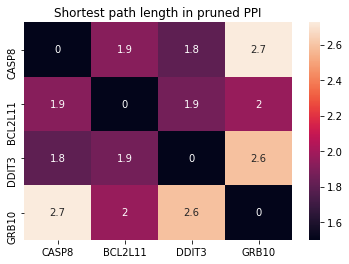

<IPython.core.display.Javascript object>

In [77]:
sp_dist = np.zeros([4, 4])
for i in range(4):
    for j in range(4):
        sp_dist[i, j] = nx.shortest_path_length(
            ppi_v3, targets[i], targets[j], weight="spearmanr"
        )
sp_dist = pd.DataFrame(sp_dist, index=targets, columns=targets)
sns.heatmap(sp_dist, vmin=1.5, annot=True)
plt.title("Shortest path length in pruned PPI")

In [67]:
pcst.edges(data=True)

EdgeDataView([('CASK', 'BNIP3L', {'pearsonr': 0.9470473661748289, 'spearmanr': 0.9473076596933884, 'mi': 1.2961580013653775, 'pearsonp': 0.9500000000000001, 'spearmanp': 0.9500000000000001, 'cost': 0.9473076596933884}), ('CASK', 'GCNT3', {'pearsonr': 0.9764692600534307, 'spearmanr': 0.9853930500406578, 'mi': 0.3401625240179867, 'pearsonp': 0.76, 'spearmanp': 0.66, 'cost': 0.9853930500406578}), ('CASK', 'CNTNAP2', {'pearsonr': 0.9672982046144156, 'spearmanr': 0.9496503077143784, 'mi': 0.6174057404553697, 'pearsonp': 0.85, 'spearmanp': 0.9400000000000001, 'cost': 0.9496503077143784}), ('RPS14', 'RPS6', {'pearsonr': 0.47228586444704446, 'spearmanr': 0.46831077623359263, 'mi': 0.6717683955419695, 'pearsonp': 1.0, 'spearmanp': 1.0, 'cost': 0.46831077623359263}), ('RPS14', 'RPS7', {'pearsonr': 0.4328949929231709, 'spearmanr': 0.4568518881529553, 'mi': 0.8257809339481055, 'pearsonp': 1.0, 'spearmanp': 1.0, 'cost': 0.4568518881529553}), ('RPS14', 'RPS25', {'pearsonr': 0.4132918520147896, 'spea

<IPython.core.display.Javascript object>

In [74]:
sp_dist

,CASP8,BCL2L11,DDIT3,GRB10
CASP8,0.000000,7.321746,3.513875,7.627930
BCL2L11,7.321746,0.000000,6.546948,11.861443
DDIT3,3.513875,6.546948,0.000000,8.053572
GRB10,7.627930,11.861443,8.053572,0.000000


<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Shortest path length in PCST (max ORF, abs. logFC, Spearman r)')

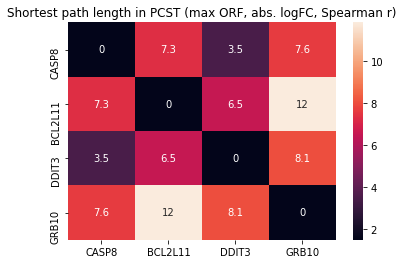

<IPython.core.display.Javascript object>

In [76]:
sp_dist = np.zeros([4, 4])
for i in range(4):
    for j in range(4):
        sp_dist[i, j] = nx.shortest_path_length(
            nx.Graph(pcst), targets[i], targets[j], weight="spearmanr"
        )
sp_dist = pd.DataFrame(sp_dist, index=targets, columns=targets)
sns.heatmap(sp_dist, vmin=1.5, annot=True)
plt.title("Shortest path length in PCST (max ORF, abs. logFC, Spearman r)")

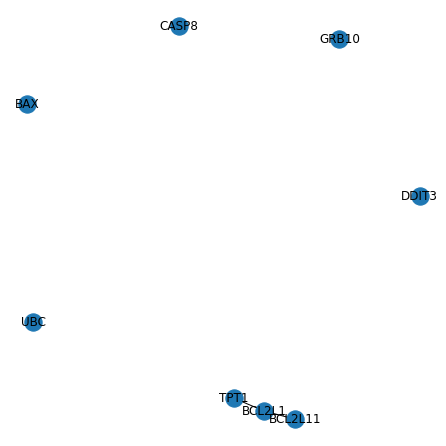

<IPython.core.display.Javascript object>

In [125]:
plt.figure(figsize=[6, 6])
nx.draw(
    pcst.subgraph(
        [
            "CASP8",
            "BAX",
            "DDIT3",
            "GRB10",
            "BCL2L11",
            "TPT1",
            "UBC",
            "TPC",
            "BCL2",
            "BCL2L1",
        ]
    ),
    with_labels=True,
    pos=nx.spring_layout(
        pcst.subgraph(
            [
                "CASP8",
                "BAX",
                "DDIT3",
                "GRB10",
                "TPT1",
                "BCL2L11",
                "UBC",
                "TPC",
                "BCL2",
                "BCL2L1",
            ]
        )
    ),
)

In [127]:
nx.shortest_path(pcst, "CASP8", "BCL2L11", weight="pearsonp")

['CASP8',
 'SQSTM1',
 'CDK1',
 'AURKB',
 'NDC80',
 'AURKA',
 'TACC3',
 'AKAP9',
 'MAGED1',
 'HSPB1',
 'TPT1',
 'BCL2L1',
 'BCL2L11']

<IPython.core.display.Javascript object>

In [112]:
ppi_v3.degree("UBC") / len(ppi_v3.nodes())

0.598007563877871

<IPython.core.display.Javascript object>

In [114]:
pcst.degree("UBC") / len(pcst.nodes())

0.10622065727699531

<IPython.core.display.Javascript object>

In [124]:
nx.shortest_path_length(ppi_v3, "DDIT3", "CASP8", weight="spearmanr")

1.8009333297257553

<IPython.core.display.Javascript object>

In [44]:
nx.shortest_path_length(ppi_v3, "DDIT3", "CASP8", weight="spearmanr")

1.8009333297257553

<IPython.core.display.Javascript object>

In [45]:
nx.shortest_path_length(ppi_v3, "BCL2L11", "CASP8", weight="spearmanr")

1.9174856485400475

<IPython.core.display.Javascript object>

#### Louvain clustering

In [151]:
partition = community.best_partition(pcst, resolution=3, randomize=True)

In [152]:
cluster_dict = {}
for k, v in partition.items():
    if v not in cluster_dict:
        cluster_dict[v] = [k]
    else:
        cluster_dict[v].append(k)

In [153]:
for k,v in cluster_dict.items():
    print("ORF targets in cluster {}: {}".format(k, list(set(v).intersection(orf_targets))))

ORF targets in cluster 0: []
ORF targets in cluster 27: ['ATM', 'ELK1', 'EIF2A', 'PPARGC1A', 'MLST8', 'PHLPP1', 'EIF4EBP1', 'CEBPA', 'XIAP', 'AKT1S1', 'REL', 'MAPKAP1']
ORF targets in cluster 2: ['TSC1', 'VHL', 'XBP1', 'SDHA', 'E2F1', 'DIABLO', 'RHOA']
ORF targets in cluster 3: ['GRB10', 'STAT1', 'CCNE1', 'CDK4', 'SLIRP', 'CDK2']
ORF targets in cluster 4: ['CREB1', 'SREBF1', 'PKIA', 'BRCA1', 'SMAD5', 'CCND1', 'DVL3', 'CTNNB1']
ORF targets in cluster 5: ['LRPPRC', 'MCL1', 'DUSP1', 'MAPK14', 'RPTOR', 'MAPK9', 'MAPK8', 'RHEB', 'BCL2L1', 'BCL2L11']
ORF targets in cluster 6: ['STK3', 'CASP8', 'ATG16L1', 'RB1']
ORF targets in cluster 7: ['IKBKB', 'TRAF6', 'HIF1A', 'CDKN1A', 'STAT3', 'TP53', 'PTEN', 'CRY1', 'RELA', 'CARD11', 'MAPK7', 'BAX', 'CYLD', 'SMAD7', 'EGLN1', 'FH']
ORF targets in cluster 8: ['VEGFC']
ORF targets in cluster 9: ['RPS6KB1', 'ARAF', 'CXXC4']
ORF targets in cluster 10: ['BMP2', 'RIPK1']
ORF targets in cluster 14: ['APAF1', 'ADAM17', 'CASP9']
ORF targets in cluster 12: ['PPP

In [102]:
set(cluster_dict[1]).intersection(orf_targets)

{'EIF2A', 'ELK1', 'PHLPP1', 'PPARGC1A', 'XIAP'}

In [103]:
set(cluster_dict[2]).intersection(orf_targets)

{'E2F1', 'VHL', 'XBP1'}

In [104]:
set(cluster_dict[3]).intersection(orf_targets)

{'CCNE1'}